# Second step in pipeline

In [7]:
import random
import numpy as np
import pandas as pd
import scienceplots
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

## Implement TopicTiling Algorithm (Riedl, Biemann, 2012)

In [2]:
# Functions for segmentation. Last function calls all of the above. 

def window_cosine_sim(dataframe, window_size=3):
    """
    Compute the cosine similarities between consecutive window blocks in a given dataframe.

    Args:
        dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
        window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
        numpy.ndarray: An array of cosine similarities between consecutive window blocks.
    """
    transcript_cosine_similarities = [] 

    for p in range(window_size, len(dataframe)-window_size):
        w_l = dataframe.topic_probs[p-window_size:p]
        w_r = dataframe.topic_probs[p:p+window_size]

        # Add probability vectors in blocks
        w_l_added = np.add.reduce(w_l)
        w_r_added = np.add.reduce(w_r)

        # Compute cosine similarity between summed vecors of the windows
        transcript_cosine_similarities.append(np.dot(w_l_added, w_r_added)/(np.linalg.norm(w_l_added) * np.linalg.norm(w_r_added)))
        
    return np.array(transcript_cosine_similarities)


def find_minimas(window_cosines, window_size, print_state, height_param):
    """
    Find the minimas in the cosine similarity values.

    Args:
        window_cosines (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
        window_size (int): The size of the window used for cosine similarity computation.
        print_state (bool): print information about candidate boundaries.
        height_param (float, optional): The minimum height for a peak to be considered a minima. Defaults to -0.995.

    Returns:
        numpy.ndarray: An array containing the indices of the identified minimas.
    """
    window_cosines_neg = window_cosines*-1
    # Find index of minimas
    minimas, _ = find_peaks(window_cosines_neg, height=height_param*-1)
    if print_state == 1:
        for position in minimas:
            print(f"Candidate boundary at sent. {position+window_size}, p:{position}, value (cos sim): {window_cosines[position]:.4f}")
    
    return minimas


def hl(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the left of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the left of the given position.
    """
    max_val = cos_sims[p]
    for i in range(p-1, 0, -1):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def hr(p, cos_sims):
    """
    Compute the maximum value of the cosine similarities to the right of the given position.

    Args:
        p (int): The position in the cosine similarities array.
        cos_sims (numpy.ndarray): An array of cosine similarities.

    Returns:
        float: The maximum value of the cosine similarities to the right of the given position
    """
    max_val = cos_sims[p]
    for i in range(p+1, len(cos_sims)):
        if cos_sims[i] > max_val:
            max_val = cos_sims[i]
        else:
            break
    return max_val


def depth_scores(cos_sims, minimas):
    """
    Calculate the depth scores for each minima in the cosine similarities.
    Args:
    cos_sims (numpy.ndarray): An array of cosine similarities.
    minimas (numpy.ndarray): An array containing the indices of the identified minimas.

    Returns:
    list: A list of depth scores for each minima.
    """
    scores = []
    for p in minimas:
        dp = 0.5 * (hl(p, cos_sims) + hr(p, cos_sims) - cos_sims[p]*2)
        scores.append(dp)
    return scores


def segment_boundaries(depth_scores, minimas_list, window_size, print_state):
    """
    Determine the segment boundaries based on depth scores and a threshold value.
    Args:
    depth_scores (list): A list of depth scores for each minima.
    minimas_list (numpy.ndarray): An array containing the indices of the identified minimas.
    window_size (int): The size of the window used for cosine similarity computation.
    print_state (bool): print information about segment boundaries.


    Returns:
    list: A list of segment boundaries.
    """
    threshold = np.mean(depth_scores) - (np.std(depth_scores)/2)
    boundaries = []
    for index, score in enumerate(depth_scores):
        if score >= threshold:
            boundaries.append(minimas_list[index] + window_size)
            if print_state == 1:
                print(f"Boundary at sentence {minimas_list[index] + window_size}, p:{minimas_list[index]}, depth score: {score:.4f}")
    return boundaries


def plot_cosine_scores(cosine_similarities_for_windows, window_size, boundaries=None):
    """
    Plot the cosine similarities and negative cosine similarities over transcript windows.

    Args:
    cosine_similarities_for_windows (numpy.ndarray): An array of cosine similarities between consecutive window blocks.
    window_size (int): window sice of segmenter algorithm. Used in title.
    boundaries (list, optional): List of int:s containing placements of segment boundaries. 
    """
    plt.style.use(['science','no-latex'])
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 3))
    sns.lineplot(cosine_similarities_for_windows, ax=axs[0])
    axs[0].set_xlabel("p")
    axs[0].set_ylabel("Cosine similarity")
    if boundaries != None:
        for seg_bound in boundaries:
            axs[0].axvline(seg_bound-window_size, color='r')

    neg_cosines_of_windows= cosine_similarities_for_windows*-1
    sns.lineplot(neg_cosines_of_windows, ax=axs[1])
    axs[1].set_xlabel("p")
    axs[1].set_ylabel("Negative cosine similarity")

    fig.suptitle(f"Cos. Sim. Over Transcript Windows with Segments Marked in Red [window size: {window_size}]")
    plt.show()


def segmentation_main_call(dataframe, print_state_min, print_state_depth, height=0.995, window=3):
    """
    Perform text segmentation by finding segment boundaries based on cosine similarity values.

    Args:
    dataframe (pandas.DataFrame): A dataframe containing topic probabilities.
    print_state_min (bool): print information about candidate boundaries.
    print_state_depth (bool): print information about segment boundaries.
    window_size (int, optional): The size of the window to use for cosine similarity computation. Defaults to 3.

    Returns:
    list: A list of segment boundaries.
    """
    window_cosines = window_cosine_sim(dataframe, window_size=window)
    min = find_minimas(window_cosines, print_state=print_state_min, window_size=window, height_param=height)
    ds = depth_scores(window_cosines, min)
    bounds = segment_boundaries(ds, min, window_size=window, print_state=print_state_depth)
    return bounds

### Pipeline step 2

In [19]:
# load sentence probabilities from 1 step
sent_proba = np.load('probabilities.npy')
print(sent_proba.shape)

# make dataframe for processing
pipeline_df = pd.DataFrame({"sentence_no":[i for i in range(len(sent_proba))], "topic_probs": list(sent_proba)})
pipeline_df.head(2)

(468, 256)


,sentence_no,topic_probs
0,0,"[2.8352589e-316, 4.2456434e-316, 5.2319785e-31..."
1,1,"[1.1875174381654893e-91, 1.725052522922942e-91..."


0.5448366784174007
0.001482188332998714
0.06967411532281836


<Axes: >

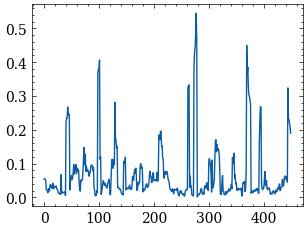

In [20]:
print(cos_sims.max())
print(cos_sims.min())
print(cos_sims.mean())
sns.lineplot(cos_sims)

Window size: 1, segments: 66


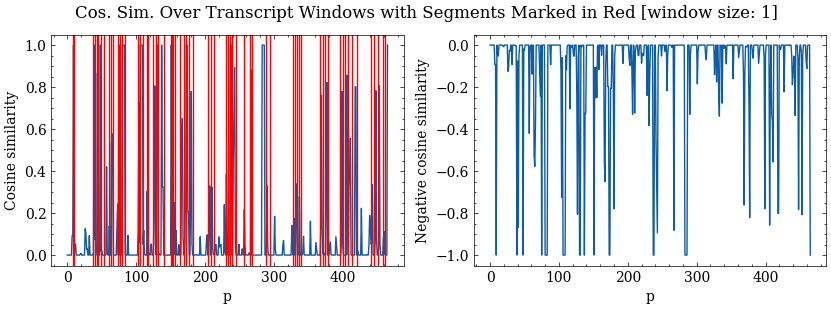

Window size: 3, segments: 60


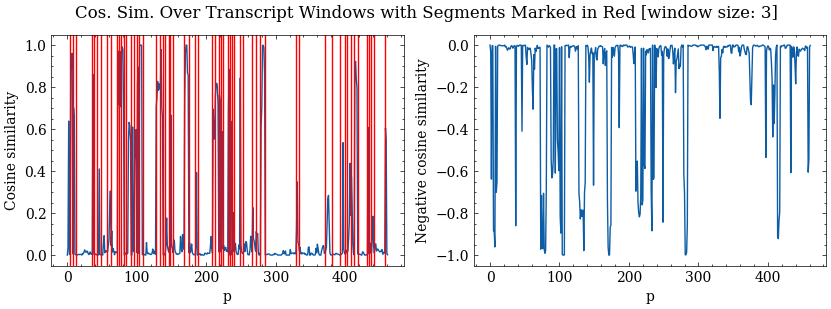

Window size: 5, segments: 60


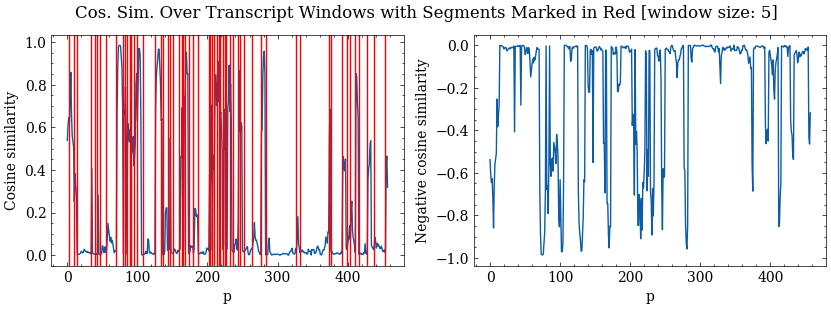

Window size: 7, segments: 50


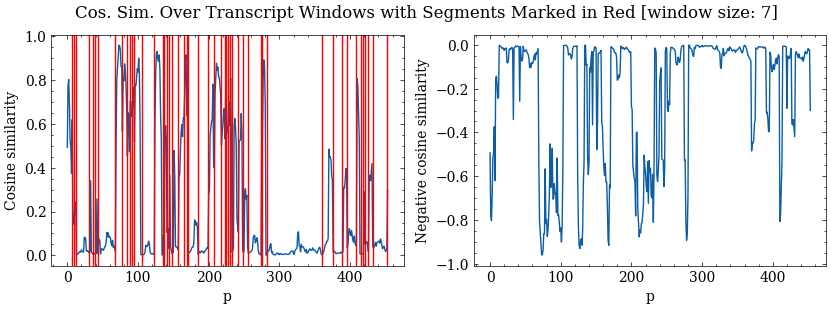

Window size: 9, segments: 56


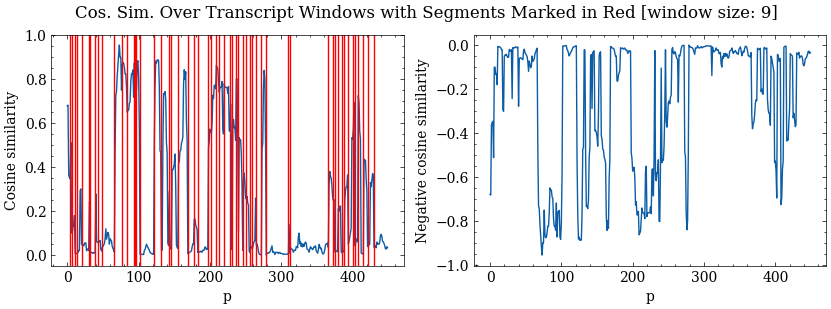

In [21]:
# Plot and analyse with different size windows
windows = [i for i in range(1, 10,2)]

for win in windows:
    bounds = segmentation_main_call(pipeline_df, print_state_min=False, print_state_depth=False, window=win, height=0.995)
    cos_sims = window_cosine_sim(pipeline_df, window_size=win)
    print(f'Window size: {win}, segments: {len(bounds)}')
    plot_cosine_scores(cos_sims, window_size=win, boundaries=bounds)

## Testing with synthetic data

### Generate synthetic data

In [11]:
# Generate synthetic topic probabilities
def generate_topic_probs(num_topics, num_sentences, topic_shift_interval):
    topic_probs = []

    np.random.seed(42)
    for i in range(num_sentences):
        if i % topic_shift_interval == 0:
            current_topic = np.random.dirichlet(np.ones(num_topics))
        
        noise = np.random.uniform(0.01, 0.05, num_topics)
        noisy_current_topic = current_topic + noise
        noisy_current_topic /= np.sum(noisy_current_topic)
        
        topic_probs.append(noisy_current_topic)

    return topic_probs

# Parameters for the synthetic dataset
num_topics = 5
num_sentences = 50
topic_shift_interval = 10

# Create the synthetic dataset
topic_probs = generate_topic_probs(num_topics, num_sentences, topic_shift_interval)

testing_df = pd.DataFrame({"sentence_no":[i for i in range(len(topic_probs))], "topic_probs": topic_probs})
testing_df.head()

,sentence_no,topic_probs
0,0,"[0.08385716116533869, 0.4577269140883433, 0.23..."
1,1,"[0.07960811538795794, 0.4925288864249926, 0.23..."
2,2,"[0.08679586102928998, 0.4772173114150449, 0.22..."
3,3,"[0.10163211228247594, 0.4691453126857391, 0.21..."
4,4,"[0.1067637438686018, 0.466769664868021, 0.2241..."


### Testing

[0.08385716 0.45772691 0.2344955  0.16528011 0.05864032]
[0.07960812 0.49252889 0.23473014 0.1526237  0.04050916]
[0.08679586 0.47721731 0.22777449 0.16309687 0.04511547]
[0.10163211 0.46914531 0.21844521 0.16000815 0.05076921]
[0.10676374 0.46676966 0.22417535 0.16643787 0.03585337]
[0.09835936 0.45579319 0.20390132 0.17517113 0.06677501]
[0.10683987 0.46722202 0.20805674 0.16850224 0.04937913]
[0.08434952 0.48258922 0.20962218 0.17961484 0.04382424]
[0.10212683 0.46926302 0.22368809 0.16431898 0.04060308]
[0.10566991 0.45440294 0.22312931 0.16522338 0.05157446]
[0.70313055 0.04310884 0.0962507  0.03373819 0.12377173]
[0.69820436 0.03794984 0.09392259 0.02344555 0.14647767]
[0.70736575 0.04002402 0.0663693  0.04925695 0.13698398]
[0.71708986 0.06089325 0.06984644 0.03389145 0.118279  ]
[0.7181946  0.05538407 0.07852564 0.02335204 0.12454364]
[0.67875944 0.05738673 0.08668667 0.05077609 0.12639108]
[0.67464202 0.05707359 0.09128437 0.0398238  0.13717621]
[0.72078177 0.05299312 0.083732

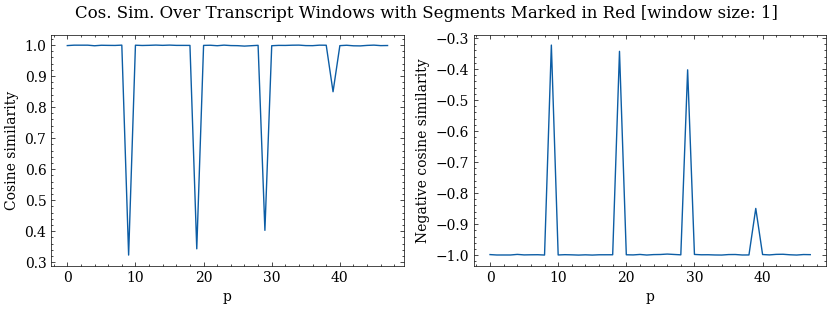

[0.08385716 0.45772691 0.2344955  0.16528011 0.05864032]
[0.07960812 0.49252889 0.23473014 0.1526237  0.04050916]
[0.08679586 0.47721731 0.22777449 0.16309687 0.04511547]
[0.10163211 0.46914531 0.21844521 0.16000815 0.05076921]
[0.10676374 0.46676966 0.22417535 0.16643787 0.03585337]
[0.09835936 0.45579319 0.20390132 0.17517113 0.06677501]
[0.10683987 0.46722202 0.20805674 0.16850224 0.04937913]
[0.08434952 0.48258922 0.20962218 0.17961484 0.04382424]
[0.10212683 0.46926302 0.22368809 0.16431898 0.04060308]
[0.10566991 0.45440294 0.22312931 0.16522338 0.05157446]
[0.70313055 0.04310884 0.0962507  0.03373819 0.12377173]
[0.69820436 0.03794984 0.09392259 0.02344555 0.14647767]
[0.70736575 0.04002402 0.0663693  0.04925695 0.13698398]
[0.71708986 0.06089325 0.06984644 0.03389145 0.118279  ]
[0.7181946  0.05538407 0.07852564 0.02335204 0.12454364]
[0.67875944 0.05738673 0.08668667 0.05077609 0.12639108]
[0.67464202 0.05707359 0.09128437 0.0398238  0.13717621]
[0.72078177 0.05299312 0.083732

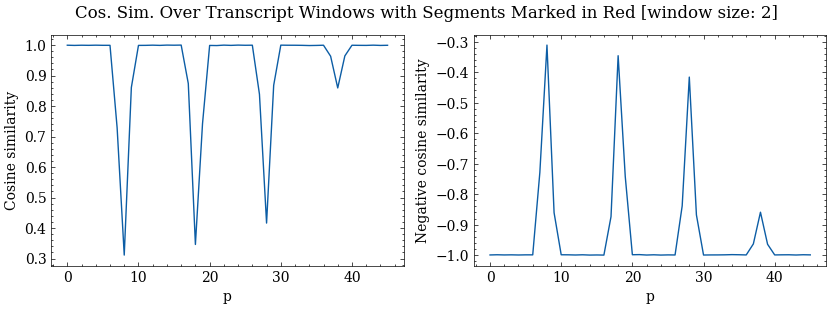

[0.16346528 0.9502558  0.46922564 0.31790381 0.09914947]
[0.16640398 0.9697462  0.46250463 0.31572057 0.08562463]
[0.18842797 0.94636262 0.44621969 0.32310502 0.09588468]
[0.20839586 0.93591498 0.44262056 0.32644602 0.08662259]
[0.2051231  0.92256285 0.42807667 0.34160899 0.10262839]
[0.20519923 0.92301521 0.41195806 0.34367337 0.11615414]
[0.19118939 0.94981124 0.41767892 0.34811708 0.09320337]
[0.18647635 0.95185224 0.43331027 0.34393383 0.08442731]
[0.20779674 0.92366595 0.4468174  0.32954236 0.09217754]
[0.80880046 0.49751178 0.31938001 0.19896157 0.17534619]
[1.4013349  0.08105868 0.19017329 0.05718374 0.2702494 ]
[1.40557011 0.07797385 0.16029189 0.07270249 0.28346165]
[1.42445561 0.10091727 0.13621574 0.0831484  0.25526299]
[1.43528446 0.11627733 0.14837208 0.05724349 0.24282264]
[1.39695404 0.11277081 0.16521231 0.07412813 0.25093471]
[1.35340146 0.11446032 0.17797104 0.09059989 0.26356729]
[1.3954238  0.11006671 0.17501689 0.06232092 0.25717167]
[1.40476929 0.10843569 0.161114

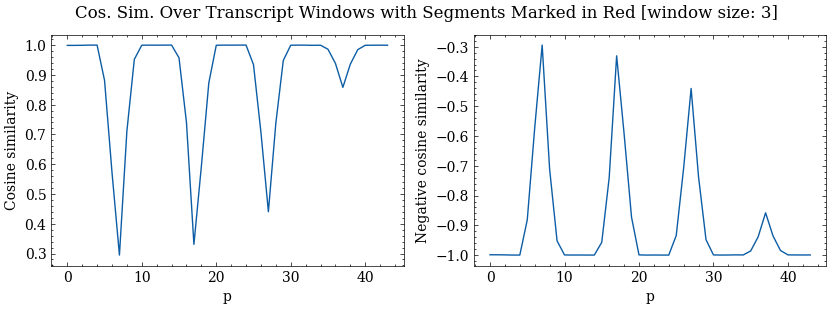

[0.25026114 1.42747311 0.69700013 0.48100068 0.14426494]
[0.26803609 1.43889151 0.68094984 0.47572872 0.13639384]
[0.29519172 1.41313229 0.67039505 0.48954289 0.13173806]
[0.30675521 1.39170817 0.64652188 0.50161714 0.1533976 ]
[0.31196297 1.38978487 0.63613341 0.51011123 0.15200752]
[0.28954875 1.40560443 0.62158024 0.52328821 0.15997838]
[0.29331623 1.41907426 0.64136701 0.51243607 0.13380644]
[0.29214626 1.40625517 0.65643958 0.50915721 0.13600178]
[0.91092729 0.96677479 0.5430681  0.36328055 0.21594927]
[1.50700481 0.53546161 0.4133026  0.22240711 0.32182386]
[2.10870066 0.12108269 0.25654259 0.10644068 0.40723338]
[2.12265997 0.13886711 0.23013833 0.10659394 0.40174066]
[2.14265021 0.15630134 0.21474138 0.10650044 0.37980662]
[2.1140439  0.17366406 0.23505875 0.10801958 0.36921372]
[2.07159606 0.1698444  0.25649668 0.11395193 0.38811093]
[2.07418323 0.16745345 0.26170356 0.11309701 0.38356275]
[2.07941131 0.16550929 0.25239912 0.10103827 0.40164202]
[2.11310871 0.15714005 0.256144

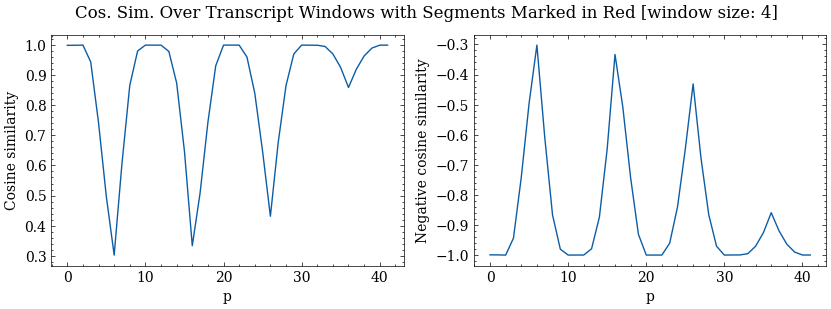

[0.35189325 1.89661842 0.91544534 0.64100883 0.19503416]
[0.37479983 1.90566118 0.90512519 0.64216659 0.17224722]
[0.39355107 1.86892548 0.87429637 0.66471402 0.19851307]
[0.41359509 1.85893018 0.85457862 0.67011938 0.20277673]
[0.39631249 1.87237409 0.84575559 0.68972607 0.19583175]
[0.39167558 1.87486744 0.84526833 0.68760719 0.20058145]
[0.39898614 1.87347719 0.86449632 0.67765945 0.18538091]
[0.99527681 1.44936401 0.75269028 0.54289539 0.2597735 ]
[1.60913165 1.00472463 0.63699069 0.3867261  0.36242694]
[2.21437057 0.57548563 0.4796719  0.27166406 0.45880785]
[2.82579051 0.18197595 0.32638903 0.14033213 0.52551239]
[2.84085457 0.19425118 0.30866397 0.12994599 0.5262843 ]
[2.82140965 0.21368807 0.30142805 0.15727653 0.5061977 ]
[2.78868592 0.23073765 0.32634312 0.14784338 0.50638993]
[2.79237784 0.22283752 0.3402292  0.13644905 0.50810639]
[2.75817075 0.22289602 0.33908579 0.15181435 0.52803309]
[2.78775073 0.21421365 0.34742849 0.13069093 0.5199162 ]
[2.20075202 0.21833499 0.656459

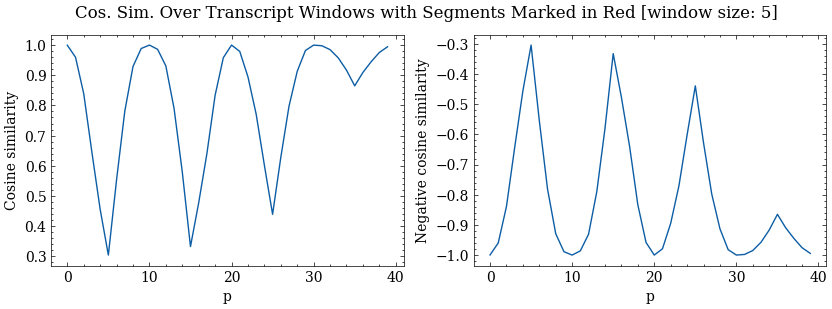

[0.45865699 2.36338809 1.13962069 0.8074467  0.23088753]
[0.47315919 2.36145436 1.10902651 0.81733771 0.23902223]
[0.50039095 2.33614749 1.0823531  0.83321626 0.2478922 ]
[0.4979446  2.34151941 1.0642008  0.84973423 0.24660096]
[0.49843933 2.34163711 1.06944368 0.85404506 0.23643483]
[0.49734549 2.32927038 1.06839764 0.85283057 0.25215592]
[1.10211668 1.91658603 0.96074702 0.71139763 0.30915263]
[1.69348117 1.48731385 0.84661287 0.56634094 0.40625118]
[2.3164974  1.04474865 0.70335999 0.43598304 0.49941092]
[2.93146042 0.63637888 0.54951834 0.30555551 0.57708685]
[3.54398511 0.23736002 0.40491467 0.16368417 0.65005602]
[3.519614   0.25163791 0.39535064 0.18072207 0.65267537]
[3.49605167 0.27076167 0.39271242 0.19710033 0.64337391]
[3.50946769 0.28373077 0.41007564 0.1703405  0.62638539]
[3.47636535 0.27828009 0.41761143 0.1751664  0.65257673]
[3.46651017 0.27160038 0.43411516 0.18146702 0.64630728]
[2.87539404 0.27540859 0.74774347 0.40909769 0.69235621]
[2.2890191  0.28475828 1.074438

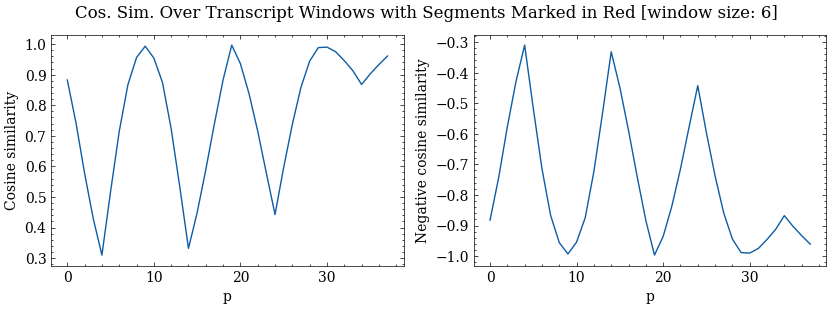

[0.55701635 2.81918128 1.34352201 0.98261782 0.29766254]
[0.57999906 2.82867638 1.31708325 0.98583995 0.28840136]
[0.58474046 2.81873672 1.29197528 1.0128311  0.29171643]
[0.60007144 2.81078242 1.28788889 1.01405321 0.28720404]
[0.60410924 2.79604004 1.29257299 1.01926844 0.28800929]
[1.20047604 2.37237922 1.16464834 0.88656876 0.37592765]
[1.80032104 1.95453587 1.05466961 0.73484318 0.45563031]
[2.40084692 1.52733787 0.91298217 0.61559789 0.54323516]
[3.03358726 1.1056419  0.77320643 0.46987449 0.61768993]
[3.64965502 0.69176296 0.62804398 0.32890755 0.70163049]
[4.22274455 0.29474675 0.49160134 0.21446026 0.7764471 ]
[4.19425603 0.3087115  0.48663501 0.22054587 0.78985158]
[4.21683345 0.32375479 0.47644494 0.21959745 0.76336938]
[4.19345521 0.33917334 0.48745787 0.20905785 0.77085574]
[4.18470477 0.32698445 0.5126408  0.20481907 0.77085092]
[3.55415348 0.33279532 0.83443014 0.45987378 0.81874728]
[2.96366112 0.34183187 1.16572251 0.66924297 0.85954153]
[2.36330669 0.34787008 1.507391

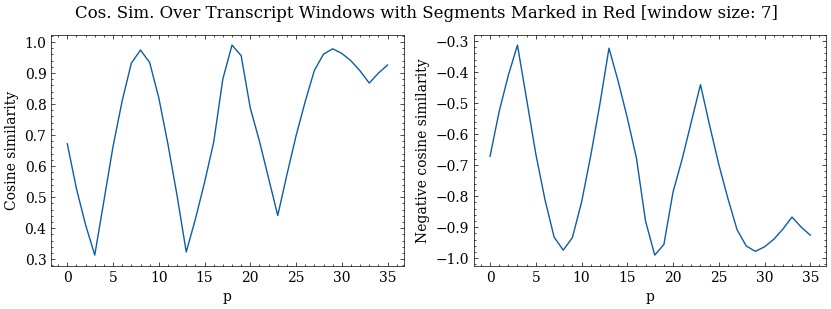

[0.66385622 3.2864033  1.55157875 1.15112006 0.34704167]
[0.66434858 3.3112656  1.52670543 1.1654548  0.33222559]
[0.6868673  3.28799973 1.51566337 1.17715008 0.33231951]
[0.70574135 3.26518536 1.5110182  1.17927659 0.33877851]
[1.30723978 2.83914888 1.38882369 1.05300662 0.41178102]
[1.8986804  2.41032906 1.25857092 0.91001431 0.52240532]
[2.50768679 1.99455989 1.12103891 0.78410013 0.59261429]
[3.11793678 1.58823112 0.98282861 0.64948934 0.66151416]
[3.75178186 1.16102597 0.85173207 0.49322654 0.74223356]
[4.32841446 0.74914969 0.71473065 0.37968364 0.82802156]
[4.89738658 0.35182034 0.58288571 0.25428406 0.91362331]
[4.9150378  0.36170463 0.57036753 0.24304299 0.90984705]
[4.90082096 0.37919736 0.55382717 0.25831479 0.90783972]
[4.90179462 0.3878777  0.58248724 0.23871051 0.88912992]
[4.27234808 0.38817939 0.91295578 0.48322582 0.94329092]
[3.64242056 0.3992186  1.25240918 0.72001905 0.9859326 ]
[3.03794871 0.40494367 1.59867609 0.92343864 1.03499289]
[2.43878412 0.39121963 1.923089

In [15]:
# Evaluate differente window sizes on synthetic data

windows_ls = [i for i in range(1, 8, 1)]

for window in windows_ls:
    con_sim = window_cosine_sim(testing_df, window_size = window)
    plot_cosine_scores(con_sim, window_size=window)
    segmentation_main_call(testing_df, window=window, print_state_min=False, print_state_depth=True)
    print()
    print()